In [1]:
import re

import nltk
nltk.download('stopwords')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stanza
stanza.download('pt')
stanza.download('en')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gianpaolo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
2020-11-17 01:07:09 INFO: Downloading default packages for language: pt (Portuguese)...
2020-11-17 01:07:09 INFO: File exists: C:\Users\Gianpaolo\stanza_resources\pt\default.zip.
2020-11-17 01:07:12 INFO: Finished downloading models and saved to C:\Users\Gianpaolo\stanza_resources.
2020-11-17 01:07:12 INFO: Downloading default packages for language: en (English)...
2020-11-17 01:07:13 INFO: File exists: C:\Users\Gianpaolo\stanza_resources\en\default.zip.
2020-11-17 01:07:18 INFO: Finished downloading models and saved to C:\Users\Gianpaolo\stanza_resources.


In [2]:
def read():
    return pd.read_csv("dataset/Corona_NLP_train.csv"), \
           pd.read_csv("dataset/Corona_NLP_test.csv")
    # df = pd.read_csv('dataset/Covid BR Tweets/opcovidbr.csv', index_col='Id')
    
    # return train_test_split(df, test_size=0.2, random_state=123)

def remove_urls(text):
    url_remover = re.compile(r'https?://\S+|www\.\S+')
    return url_remover.sub(r'', text)   
    
def remove_html(text):
    html_remover=re.compile(r'<.*?>')
    return html_remover.sub(r'',text)

def remove_mentions(text):
    mention_remover=re.compile(r'@\w+')
    return mention_remover.sub(r'',text)

def remove_numbers(text):
    number_remover=re.compile(r'\d+')
    return number_remover.sub(r'',text)

def remove_hashtags(text):
    number_remover=re.compile(r'#\w+')
    return number_remover.sub(r'',text)

def remove_punctuation(text):
    punct_remover=re.compile(r'[^\w\s\d]+')
    return punct_remover.sub(r'',text)

def remove_excessive_whitespace(text):
    ws_remover=re.compile(r'\s+')
    return ws_remover.sub(r' ', str(text)).strip()

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))     
    # stop_words = set(stopwords.words('portuguese'))     
    return " ".join([word for word in text.split(" ") if word not in stop_words]) 
    
def lowering(text):
    return text.lower()

def lemmatization(text, nlp):
    doc = nlp(text)
    return ' '.join([f'{word.lemma}' for sent in doc.sentences for word in \
            sent.words])

def clean(df):
    df = df.loc[:,["OriginalTweet", "Sentiment"]]
    scores = {
        'Neutral': 0,     
        'Extremely Negative':-1, 
        'Negative':-1,
        'Positive':1,
        'Extremely Positive':1
    }
    
    df["score"] = df.Sentiment.apply(lambda x: scores[x])
    df.drop("Sentiment", inplace=True, axis=1)
    
    # df = df.loc[:,["twitter", "polarity"]]
    # df["score"] = df.polarity
    # df["text"] = df.twitter    
    df["text"] = df.OriginalTweet    
    df["text"] = df.text.apply(lambda x: remove_urls(x))
    df["text"] = df.text.apply(lambda x: remove_mentions(x))
    df["text"] = df.text.apply(lambda x: remove_html(x))
    df["text"] = df.text.apply(lambda x: remove_numbers(x))
    df["text"] = df.text.apply(lambda x: remove_hashtags(x))
    df["text"] = df.text.apply(lambda x: remove_punctuation(x))
    df["text"] = df.text.apply(lambda x: remove_excessive_whitespace(x))
    df["text"] = df.text.apply(lambda x: remove_stopwords(x))
    df["text"] = df.text.apply(lambda x: lowering(x))
    # Removing messages that are too short.
    df = df[df.text.apply(lambda x: len(x.split(" ")) > 2)]
    
    # nlp = stanza.Pipeline(lang='pt', processors='tokenize,mwt,pos,lemma')
    nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,lemma', use_gpu=True)
    df["text"] = df.text.apply(lambda x: lemmatization(x, nlp))
    
    
    return df

def cleaning():
    df_train, df_test = read()
    df_train = clean(df_train)
    df_test = clean(df_test)
    
    return df_train, df_test

In [3]:
df_train, df_test = cleaning()

2020-11-17 01:07:47 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2020-11-17 01:07:47 INFO: Use device: cpu
2020-11-17 01:07:47 INFO: Loading: tokenize
2020-11-17 01:07:47 INFO: Loading: pos
2020-11-17 01:07:47 INFO: Loading: lemma
2020-11-17 01:07:48 INFO: Done loading processors!
2020-11-17 02:09:24 INFO: Loading these models for language: en (English):
| Processor | Package |
-----------------------
| tokenize  | ewt     |
| pos       | ewt     |
| lemma     | ewt     |

2020-11-17 02:09:24 INFO: Use device: cpu
2020-11-17 02:09:24 INFO: Loading: tokenize
2020-11-17 02:09:24 INFO: Loading: pos
2020-11-17 02:09:24 INFO: Loading: lemma
2020-11-17 02:09:24 INFO: Done loading processors!


In [4]:
# Este é o algoritmo utilizado para vetorizar os textos dos tweets
# Precisa ser o mesmo tanto no df de treino quanto no df de teste
tfidf_fitter = TfidfVectorizer(
    sublinear_tf=True, 
    min_df=5
).fit(df_train.text)
X_train = tfidf_fitter.transform(df_train.text)
y_train = df_train.score
X_test = tfidf_fitter.transform(df_test.text)
y_test = df_test.score

In [5]:
model =  LinearSVC(verbose=1, max_iter=500, 
                   penalty='l1', loss='squared_hinge',
                   dual=False)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

[LibLinear]

CLASSIFICATION METRICS

              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84      1632
     Neutral       0.75      0.78      0.76       610
    Positive       0.84      0.87      0.85      1544

    accuracy                           0.83      3786
   macro avg       0.82      0.82      0.82      3786
weighted avg       0.84      0.83      0.84      3786



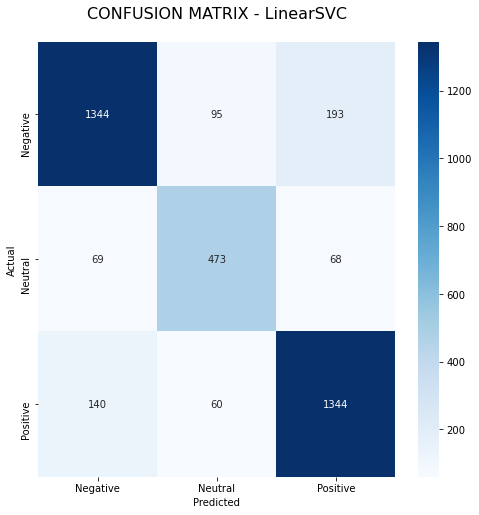

In [6]:
print('CLASSIFICATION METRICS\n')
print(classification_report(
    y_test, 
    y_pred,
    target_names=['Negative','Neutral','Positive']
))

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=['Negative','Neutral','Positive'], 
            yticklabels=['Negative','Neutral','Positive']
            )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);